In [34]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import AllChem
from rdkit.Chem import rdMolTransforms
from rdkit.Chem import DataStructs
import numpy as np
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
sdf = Chem.SDMolSupplier( "3d_amine.sdf", removeHs=False )
mols = [ m for m in sdf ]
fps = [ AllChem.GetMorganFingerprintAsBitVect( mol,2 ) for mol in mols ]
mol = mols[1]
mol.GetSubstructMatch( Chem.MolFromSmarts( "N[H]" ) )
atoms = [atom for atom in mol.GetAtoms()]

def getev( mol ):
    if mol.GetNumConformers() >= 1:
        matches = mol.GetSubstructMatches( Chem.MolFromSmarts( "N[H]" ) )
        conf = mol.GetConformer()
        theta = rdMolTransforms.GetDihedralDeg( conf,
                                                matches[0][1],
                                                matches[0][0],
                                                matches[1][0],
                                                matches[1][1]  )
        temp_phi1 = 180 - rdMolTransforms.GetAngleDeg(conf,
                                           matches[1][0],
                                           matches[0][0],
                                           matches[0][1]
                                          )
        temp_phi2 = 180 - rdMolTransforms.GetAngleDeg(conf,
                                           matches[0][0],
                                           matches[1][0],
                                           matches[1][1]
                                          )
        if temp_phi1 >= temp_phi2:
            phi1 = temp_phi1
            phi2 = temp_phi2
        else:
            phi1 = temp_phi2
            phi2 = temp_phi1
            
        r = rdMolTransforms.GetBondLength( conf, matches[0][0], matches[1][0] )
        return theta, phi1, phi2, r
    else:
        print( "No conformer!" )


def transform_cartegian( theta, phi1, phi2, r ):
    theta = np.deg2rad( theta )
    phi1 = np.deg2rad( phi1 )
    phi2 = np.deg2rad( phi2 )
    x = np.sin( theta ) * np.sin( phi1 ) * np.sin( phi2 ) *r
    y = np.sin( theta ) * np.sin( phi1 ) * np.cos( phi2 ) *r
    z = np.sin( theta ) * np.cos( phi1 ) *r
    t = np.cos( theta ) *r
    return x, y, z, t

def get_dist(v1,v2):
    v1 = np.asarray( v1 )
    v2 = np.asarray( v2 )
    delta =  v1 - v2
    d = np.linalg.norm( delta )
    return d


In [35]:
def calc_distance( mol1, mol2 ):
    theta1, phi11, phi21, r1 = getev( mol1 )
    theta2, phi12, phi22, r2 = getev( mol2 )
    cart1 = transform_cartegian( theta1, phi11, phi21, r1 )
    cart2 = transform_cartegian( theta2, phi12, phi22, r2 )
    d = get_dist( cart1, cart2 )
    return d

In [65]:
f = open( 'ditance_sim.txt','w' )
f.write( 'idx1,idx2,distance,ECFP4sim\n' )
dataset = []
for i, mol in enumerate( mols ):
    d = calc_distance(mols[3],mol)
    sim = DataStructs.TanimotoSimilarity( fps[3], fps[i] )
    if d < 2:
        print( "idx_"+str(3), "idx_"+str(i), "distance_"+str(d), "tanimoto"+str(sim) )
    else:
        pass
    f.write( '{},{},{},{}\n'.format( 3,i,d,sim ) )
    dataset.append([d,sim])
f.close()

idx_3 idx_1 distance_1.48017700543 tanimoto0.47058823529411764
idx_3 idx_3 distance_0.0 tanimoto1.0
idx_3 idx_6 distance_1.40146560569 tanimoto0.6666666666666666
idx_3 idx_7 distance_0.0619944778129 tanimoto0.6
idx_3 idx_13 distance_1.85179121146 tanimoto0.5
idx_3 idx_14 distance_1.80235655185 tanimoto0.5


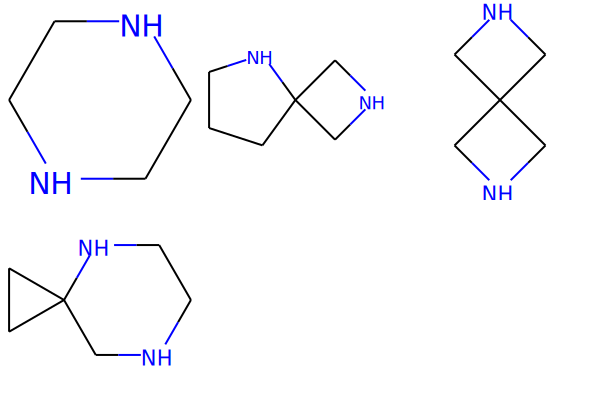

In [66]:
rhmols = [ Chem.RemoveHs(mol) for mol in mols ]
Draw.MolsToGridImage( [rhmols[3],rhmols[1], rhmols[6], rhmols[7]] )

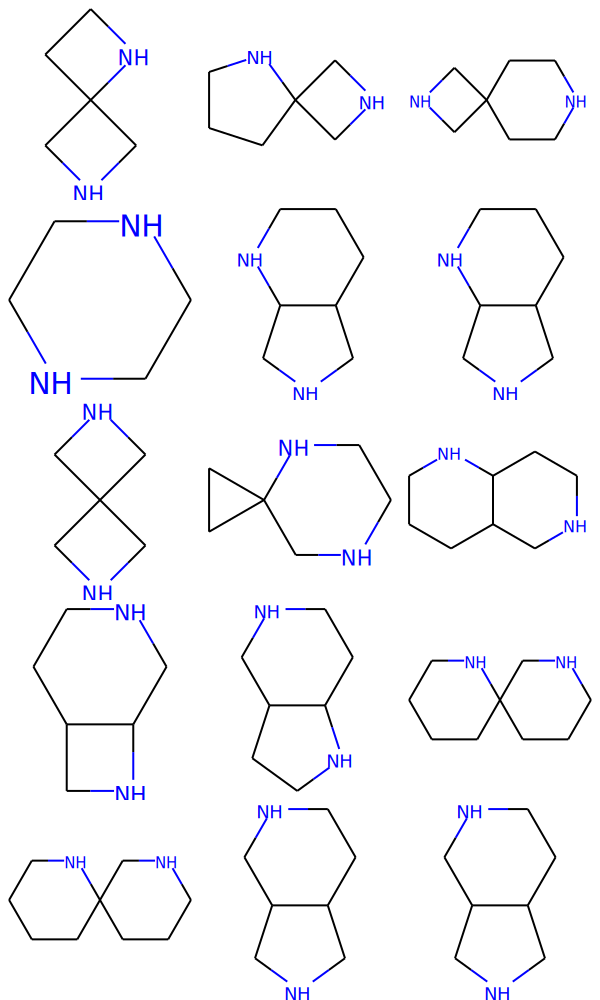

In [67]:
Draw.MolsToGridImage( rhmols )

In [68]:
df = pd.DataFrame(dataset, columns=['dist','sim'])

In [69]:
g=sns.lmplot('dist','sim',df, fit_reg=False)

/Users/iwatobipen/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/matplotlib/tight_layout.py:225: UserWarning: tight_layout : falling back to Agg renderer
  warnings.warn("tight_layout : falling back to Agg renderer")


In [70]:
plt.show(g)

/Users/iwatobipen/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):
